# Reprojection while Preserving Gradients
Below is a simple implementation demonstrating that passing the `requires_grad = True` flag allows for accumulation of gradients through reprojection.

In [1]:
!pip install sunpy

In [2]:
import sys
sys.path.append('../src')  # Adds the parent directory to the Python path
from astropy.io import fits
from astropy.wcs import WCS
from dfreproject import calculate_reprojection
from sunpy.data.sample import AIA_193_JUN2012, STEREO_A_195_JUN2012
import matplotlib.pyplot as plt
import torch
from astropy.io.fits import PrimaryHDU
from dfreproject import TensorHDU

<class 'dfreproject.tensorhdu.TensorHDU'>


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-AVG to 56079.003875 from DATE-AVG.
Set MJD-END to 56079.003922 from DATE-END'. [astropy.wcs.wcs]
/home/carterrhea/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


torch.Size([2048, 2048])
True
tensor([[10.8605,  9.4130,  6.7726,  ...,  8.6352,  9.0771, 10.3480],
        [ 8.8950,  6.2345,  5.1580,  ...,  5.6039,  5.8419,  8.0692],
        [ 8.8747,  5.5297,  4.6029,  ...,  5.1257,  4.7895,  6.9579],
        ...,
        [ 7.1081,  6.1034,  5.2919,  ...,  5.6594,  5.7236,  7.1181],
        [ 5.7055,  5.6229,  4.9817,  ...,  4.7092,  4.6731,  7.0361],
        [13.0178,  8.1580,  6.4619,  ...,  8.5611,  7.3828, 10.3059]],
       dtype=torch.float64)


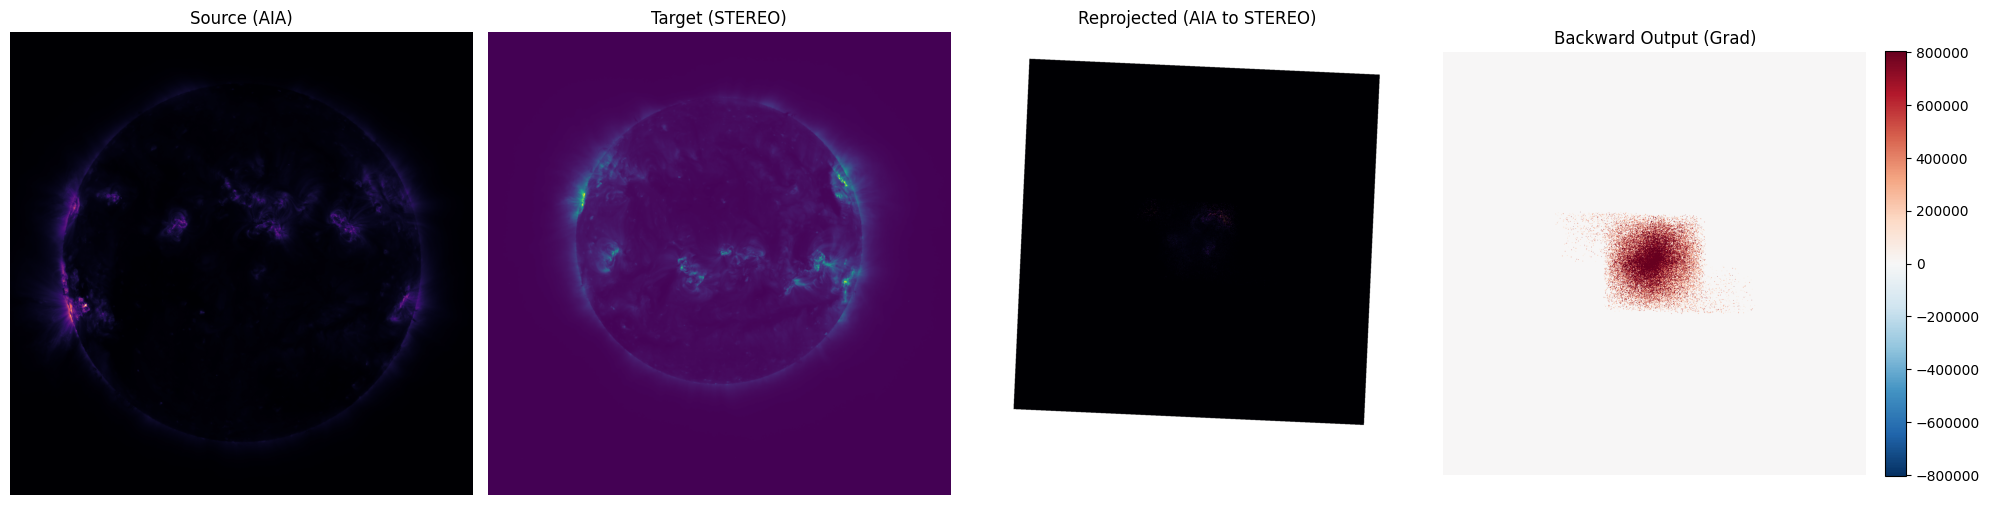

In [3]:
# Load source and target images
source_hdu = fits.open(AIA_193_JUN2012)[1]
target_hdu = fits.open(STEREO_A_195_JUN2012)[1]
source_hdu = PrimaryHDU(source_hdu.data, header=source_hdu.header)

source_hdu = TensorHDU(torch.tensor(source_hdu.data, requires_grad=True), source_hdu.header)
alt_tensor = source_hdu.tensor 
alt_header = source_hdu.header
target_hdu = PrimaryHDU(target_hdu.data, header=target_hdu.header)

target_wcs = WCS(target_hdu.header)

print(type(source_hdu))



reprojected = calculate_reprojection(
    source_hdus = source_hdu,
    target_wcs=target_wcs,
    shape_out=target_hdu.data.shape,
    order='bilinear',
    requires_grad=True,
)

print(reprojected.shape)  # Should match target_hdu.data.shape


print(reprojected.requires_grad)  # Should be True if requires_grad=True was passed
reprojected.sum().backward()
print(source_hdu.tensor.grad)
# Plot with a diverging colormap centered at zero for gradients
import numpy as np

grad = source_hdu.tensor.grad.cpu().numpy()
# Use percentiles to avoid outlier-dominated color scaling
vmax = np.nanpercentile(np.abs(grad), 99)
if vmax == 0 or np.isnan(vmax):
    vmax = 1e-8  # fallback to avoid division by zero

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(source_hdu.data, cmap='magma')
axes[0].set_title('Source (AIA)')
axes[1].imshow(target_hdu.data, cmap='viridis')
axes[1].set_title('Target (STEREO)')
axes[2].imshow(reprojected.detach(), cmap='magma')
axes[2].set_title('Reprojected (AIA to STEREO)')
im = axes[3].imshow(grad, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
axes[3].set_title('Backward Output (Grad)')
for ax in axes:
    ax.axis('off')
fig.colorbar(im, ax=axes[3], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()